In [25]:
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
from torchsummary import summary
from safetensors.torch import save_model
import matplotlib.pyplot as plt
import cv2

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [27]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale()
])

In [28]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=data_transforms
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=data_transforms
)

In [29]:
batch_size = 16

# put custom dataset to dataloader
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [30]:
# test if data can be inserted into dataloader
x, y = next(iter(train_dl))
x.shape

torch.Size([16, 1, 28, 28])

In [31]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
        )

        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)

        return latent, reconstruction
    
model = AutoEncoder().to(device)
summary(model, (1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]         100,480
              ReLU-2               [-1, 1, 128]               0
            Linear-3                [-1, 1, 32]           4,128
              ReLU-4                [-1, 1, 32]               0
            Linear-5                [-1, 1, 16]             528
              ReLU-6                [-1, 1, 16]               0
            Linear-7                 [-1, 1, 8]             136
            Linear-8                [-1, 1, 16]             144
              ReLU-9                [-1, 1, 16]               0
           Linear-10                [-1, 1, 32]             544
             ReLU-11                [-1, 1, 32]               0
           Linear-12               [-1, 1, 128]           4,224
             ReLU-13               [-1, 1, 128]               0
           Linear-14               [-1,

In [32]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

In [33]:
torch.manual_seed(42)

epochs = 10

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")
    
    # TRAINING
    train_loss =  0
    model.train()
    for batch, (X, y) in enumerate(train_dl):

        X, y = X.reshape(-1, 28 * 28).to(device), y.to(device)

        # forward pass
        train_latent, train_reconstructions = model(X)

        # metrics
        loss = loss_fn(train_reconstructions, X)
        train_loss += loss

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # print metrics
    train_loss /= len(train_dl)
    print(f"Train Loss: {train_loss:.4f}")

    
    # TESTING
    test_loss = 0
    model.eval()
    with torch.inference_mode():
        for X, y in test_dl:

            X, y = X.reshape(-1, 28 * 28).to(device), y.to(device)


            # forward pass
            test_latent, test_reconstructions = model(X)

            # metrics
            test_loss += loss_fn(test_reconstructions, X)
        
        # print metrics
        test_loss /= len(test_dl)
        print(f"Test Loss: {test_loss:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
------
Train Loss: 0.0565


 10%|█         | 1/10 [00:23<03:27, 23.09s/it]

Test Loss: 0.0355
Epoch: 1
------
Train Loss: 0.0316


 20%|██        | 2/10 [00:47<03:11, 23.96s/it]

Test Loss: 0.0279
Epoch: 2
------
Train Loss: 0.0266


 30%|███       | 3/10 [01:11<02:47, 23.93s/it]

Test Loss: 0.0256
Epoch: 3
------
Train Loss: 0.0251


 40%|████      | 4/10 [01:34<02:20, 23.38s/it]

Test Loss: 0.0246
Epoch: 4
------
Train Loss: 0.0243


 50%|█████     | 5/10 [01:57<01:56, 23.22s/it]

Test Loss: 0.0241
Epoch: 5
------
Train Loss: 0.0237


 60%|██████    | 6/10 [02:19<01:31, 22.95s/it]

Test Loss: 0.0235
Epoch: 6
------
Train Loss: 0.0232


 70%|███████   | 7/10 [02:41<01:08, 22.69s/it]

Test Loss: 0.0231
Epoch: 7
------
Train Loss: 0.0227


 80%|████████  | 8/10 [03:04<00:45, 22.66s/it]

Test Loss: 0.0226
Epoch: 8
------
Train Loss: 0.0222


 90%|█████████ | 9/10 [03:27<00:22, 22.93s/it]

Test Loss: 0.0221
Epoch: 9
------
Train Loss: 0.0217


100%|██████████| 10/10 [03:51<00:00, 23.10s/it]

Test Loss: 0.0218


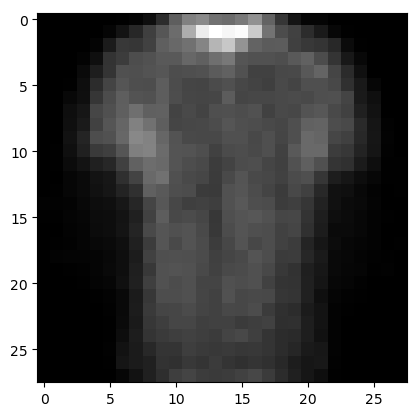

In [47]:
X, y = next(iter(train_dl))
X, y = X[0, :, :].reshape(1, 28*28).to(device), y[0].to(device)

sample_latent, sample_reconstruction = model(X)
sample_reconstruction = sample_reconstruction.reshape(28, 28).detach().cpu().numpy()

plt.imshow(sample_reconstruction, cmap="gray")